# LSTM Travel Time + Speed Prediction - Cent.0

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
traffic = pd.read_csv('../db.csv', parse_dates = ["timeStamp"])
traffic.head(10)

,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,roadName,roadClosure,timeStamp
0,64,64,21,21,N103.1,False,2021-04-26 18:11:34
1,34,43,49,39,N103.0,False,2021-04-27 14:53:37
2,64,64,21,21,N103.1,False,2021-04-27 14:53:49
3,51,51,37,37,N103.2,False,2021-04-27 14:54:00
4,74,74,21,21,N101.0,False,2021-04-27 14:54:12
5,33,43,51,39,N103.0,False,2021-04-27 14:57:10
6,64,64,21,21,N103.1,False,2021-04-27 14:57:22
7,39,50,49,38,N103.2,False,2021-04-27 14:57:33
8,74,74,21,21,N101.0,False,2021-04-27 14:57:45
9,52,67,28,21,N101.1,False,2021-04-27 14:57:57


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294475 entries, 0 to 294474
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   currentSpeed        294475 non-null  int64         
 1   freeFlowSpeed       294475 non-null  int64         
 2   currentTravelTime   294475 non-null  int64         
 3   freeFlowTravelTime  294475 non-null  int64         
 4   roadName            294475 non-null  object        
 5   roadClosure         294475 non-null  bool          
 6   timeStamp           294475 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(4), object(1)
memory usage: 13.8+ MB


In [4]:
print(traffic['roadName'].unique())

['N103.1' 'N103.0' 'N103.2' 'N101.0' 'N101.1' 'N101.2' 'N101.3' 'N101.4'
 'N101.5' 'Cent.0' 'Cent.1' 'Cent.2' 'Cent.3' 'Cent.4']


### Filter Roads

In [5]:
traffic = traffic[(traffic['roadName'] == 'Cent.0')]

### Drop unwanted columns 

In [6]:
traffic = traffic.drop(columns = ['roadClosure', 'freeFlowTravelTime', 'freeFlowSpeed', 'roadName'])

### Remove incomplete days

In [7]:
tfc = traffic[(traffic['timeStamp'].dt.day != 26) 
                        & (traffic['timeStamp'].dt.day != 27) 
                        & (traffic['timeStamp'].dt.day != 3)]

### Treat Date and Time

In [8]:
tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")

<ipython-input-8-7e39a034e481>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")


In [9]:
tfc

,currentSpeed,currentTravelTime,timeStamp
6385,10,54,2021042800
6399,10,54,2021042800
6413,10,54,2021042800
6427,10,54,2021042800
6441,10,54,2021042800
...,...,...,...
294410,11,49,2021051509
294424,11,49,2021051509
294438,11,49,2021051509
294452,11,49,2021051509


In [10]:
traffic_by_date = tfc.groupby(['timeStamp'])
traffic_by_date_mean = traffic_by_date.mean()
traffic_by_date_mean

,currentSpeed,currentTravelTime
timeStamp,,
2021042800,10.000000,54.000000
2021042801,10.000000,54.000000
2021042802,10.000000,54.000000
2021042803,10.000000,54.000000
2021042804,10.000000,54.000000
...,...,...
2021051505,11.000000,49.000000
2021051506,11.000000,49.000000
2021051507,10.509804,52.156863


### Normalize Data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

normalized_Time = traffic_by_date_mean
normalized_Speed = traffic_by_date_mean

normalized_Time[['currentTravelTime']] = scaler.fit_transform(traffic_by_date_mean[['currentTravelTime']])
normalized_Time = normalized_Time.drop(columns = ['currentSpeed'])
normalized_Time

normalized_Speed[['currentSpeed']] = scaler.fit_transform(traffic_by_date_mean[['currentSpeed']])
normalized_Speed = normalized_Speed.drop(columns = ['currentTravelTime'])
normalized_Speed

,currentSpeed
timeStamp,
2021042800,0.354430
2021042801,0.354430
2021042802,0.354430
2021042803,0.354430
2021042804,0.354430
...,...
2021051505,0.677215
2021051506,0.677215
2021051507,0.518987


In [12]:
# 24 hours that make the sequence
TIMESTEPS = 24

# number of features used by the model (using conf. cases to predict conf. cases)
FEATURES = len(normalized_Time.columns)

# number of hours to forecast - we will forecast the next 12 hours
MULTISTEPS = 12

# time series cross validator
CV_SPLITS = 5

EPOCHS = 300

# 24 hours (1 day)
BATCH_SIZE = 24

In [13]:
# split data into training and validation sets
def split_data(training, percentage = 15):
    train_idx = np.arange(0, int(len(training) * (100 - percentage) / 100))
    val_idx = np.arange(int(len(training) * (100 - percentage) / 100 + 1), len(training))
    
    return train_idx, val_idx

# LSTM - Time

In [14]:
# Preparing the dataset for the LSTM
def to_supervised(df, timesteps, features = 1):

    data = df.values
    x, y = [], []
    
    # iterate over the training set to create x and y
    dataset_size = len(data)
    
    for curr_pos in range(dataset_size):
        # end of the input sequence is the current position + the number 
        # of timesteps of the input sequence
        input_index = curr_pos + timesteps
        
        # end of the labels correspond to the end of the input sequence + 1
        label_index = input_index + 1
        
        # if we have enough data for this sequence 
        if label_index < dataset_size:
            x.append(data[curr_pos:input_index, :])
            y.append(data[input_index:label_index, 0])
        
    # using np.float32 for GPU performance
    return np.array(x).astype('float32'), np.array(y).astype('float32')


def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))
    

def build_model(timesteps, features, name, h_neurons = 128):
    
    model = tf.keras.models.Sequential(name = name)
    
    model.add(LSTM(h_neurons, return_sequences = True,
                   input_shape = (timesteps, features), 
                   activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(LSTM(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(features, activation = 'tanh'))
    
    return model


# Compiling and fit the model
def compile_and_fit(model, x, y, epochs, batch_size, cv_splits):
    callback = []
    
    callback.append(EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                                  patience = 20, verbose = 0, 
                                  mode = 'auto', restore_best_weights = True))
    
    callback.append(ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                                      patience = 20, verbose = 0,
                                      mode = 'auto', cooldown = 0, 
                                      min_lr = 0.0001))
    
    # compile
    model.compile(loss = rmse, 
                  optimizer = 'Adagrad', 
                  metrics = ['mae', rmse])    
    
    # fit
    hist_list = []
    loss_list = []
    
    # time series cross validator
    tscv = TimeSeriesSplit(n_splits = cv_splits)
    
    for train_index, test_index in tscv.split(x):
        # further split into training and validation sets
        train_idx, val_idx = split_data(train_index, percentage = 15)
        
        x_train, y_train = x[train_idx], y[train_idx]
        x_val, y_val = x[val_idx], y[val_idx]
        #x_test, y_test = x[test_index], y[test_index]
        
        history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                            epochs = epochs, batch_size = batch_size, 
                            shuffle = False, callbacks = callback)
        
        plot_learning_curves(history, model_name = model.get_config()['name'])
    
    return model, hist_list, loss_list


# Recursive Multi-step Forecast
def forecast(model, df, scaler, timesteps, multisteps, features, batch_size):
    # getting the last sequence of known value
    input_seq = df[-timesteps:].values
    inp = input_seq
    forecasts = []
    
    # multisteps tells us how many iterations we want to perform, i.e., how many days
    # we want to predict
    for step in range(1, multisteps + 1):
     
        inp = inp.reshape(1, timesteps, features)
        
        yhat = model.predict(inp)
        
        print('yhat', yhat[0][features-1])
        
        yhat_inversed = scaler.inverse_transform(yhat)
        
        print('Transformed yhat', yhat_inversed[0][features-1])
        
        forecasts.append(round(yhat_inversed[0][features-1], 1))
    
        inp = np.append(inp[0], yhat[0])
        
        inp = inp[-timesteps*features:]
        
    return forecasts


def plot_prediction(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Travel Time For The Next 12H')
    plt.ylabel('Current Travel Time (min)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()

def plot_prediction_Speed(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Speed For The Next 12H')
    plt.ylabel('Current Speed (KM/H)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()



def plot_learning_curves(history, model_name):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['rmse'], color = 'mediumpurple',linewidth=3)
    plt.plot(history.history['val_rmse'], color = 'purple',linewidth=3)
    plt.title('Model ({}) rmse'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color = 'mediumpurple', linewidth=3)
    plt.plot(history.history['val_loss'], color = 'purple', linewidth=3)
    plt.title('Model ({}) loss'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

In [15]:
# our supervised problem
x, y = to_supervised(normalized_Time, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 6s 897ms/step - loss: 0.6802 - mae: 0.6533 - rmse: 0.6993 - val_loss: 0.6293 - val_mae: 0.6107 - val_rmse: 0.6293
Epoch 2/300
3/3 [==============================] - 0s 68ms/step - loss: 0.6232 - mae: 0.5931 - rmse: 0.6416 - val_loss: 0.5724 - val_mae: 0.5608 - val_rmse: 0.5724
Epoch 3/300
3/3 [==============================] - 0s 74ms/step - loss: 0.5662 - mae: 0.5306 - rmse: 0.5813 - val_loss: 0.5260 - val_mae: 0.5190 - val_rmse: 0.5260
Epoch 4/300
3/3 [==============================] - 0s 77ms/step - loss: 0.5174 - mae: 0.4815 - rmse: 0.5395 - val_loss: 0.4859 - val_mae: 0.4816 - val_rmse: 0.4859
Epoch 5/300
3/3 [==============================] - 0s 72ms/step - loss: 0.4853 - mae: 0.4444 - rmse: 0.4997 - val_loss: 0.4501 - val_mae: 0.4469 - val_rmse: 0.4501
Epoch 6/300
3/3 [==============================] - 0s 72ms/step - loss: 0.4431 - mae: 0.4059 - rmse: 0.4588 - val_loss: 0.4175 - val_mae: 0.4138 - val_rmse: 0.4175
Epoch 7/300
3/3

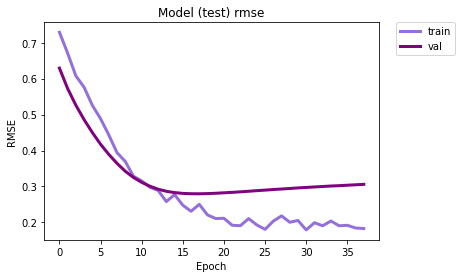

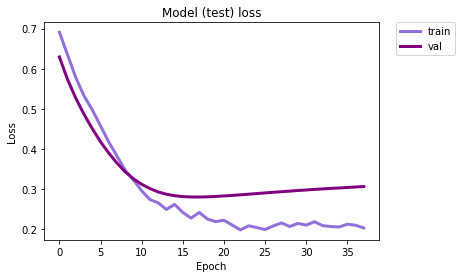

Epoch 1/300
5/5 [==============================] - 0s 94ms/step - loss: 0.2305 - mae: 0.1810 - rmse: 0.2044 - val_loss: 0.2281 - val_mae: 0.1949 - val_rmse: 0.2281
Epoch 2/300
5/5 [==============================] - 0s 69ms/step - loss: 0.2287 - mae: 0.1811 - rmse: 0.2096 - val_loss: 0.2280 - val_mae: 0.1943 - val_rmse: 0.2280
Epoch 3/300
5/5 [==============================] - 0s 91ms/step - loss: 0.2244 - mae: 0.1751 - rmse: 0.2082 - val_loss: 0.2279 - val_mae: 0.1936 - val_rmse: 0.2279
Epoch 4/300
5/5 [==============================] - 0s 79ms/step - loss: 0.2346 - mae: 0.1849 - rmse: 0.2153 - val_loss: 0.2279 - val_mae: 0.1931 - val_rmse: 0.2279
Epoch 5/300
5/5 [==============================] - 0s 74ms/step - loss: 0.2273 - mae: 0.1794 - rmse: 0.2118 - val_loss: 0.2278 - val_mae: 0.1925 - val_rmse: 0.2278
Epoch 6/300
5/5 [==============================] - 0s 73ms/step - loss: 0.2374 - mae: 0.1860 - rmse: 0.2163 - val_loss: 0.2278 - val_mae: 0.1921 - val_rmse: 0.2278
Epoch 7/300
5/5 

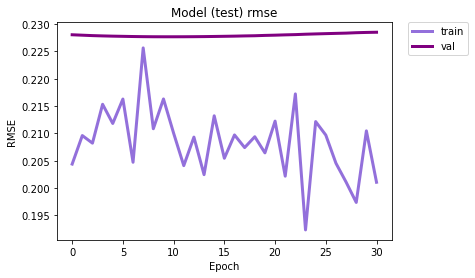

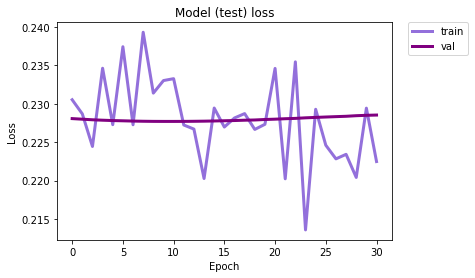

Epoch 1/300
7/7 [==============================] - 0s 70ms/step - loss: 0.2259 - mae: 0.1743 - rmse: 0.2461 - val_loss: 0.2429 - val_mae: 0.2151 - val_rmse: 0.2401
Epoch 2/300
7/7 [==============================] - 0s 64ms/step - loss: 0.2198 - mae: 0.1625 - rmse: 0.2430 - val_loss: 0.2428 - val_mae: 0.2149 - val_rmse: 0.2398
Epoch 3/300
7/7 [==============================] - 0s 63ms/step - loss: 0.2230 - mae: 0.1689 - rmse: 0.2459 - val_loss: 0.2427 - val_mae: 0.2147 - val_rmse: 0.2395
Epoch 4/300
7/7 [==============================] - 0s 67ms/step - loss: 0.2365 - mae: 0.1815 - rmse: 0.2518 - val_loss: 0.2426 - val_mae: 0.2146 - val_rmse: 0.2392
Epoch 5/300
7/7 [==============================] - 0s 62ms/step - loss: 0.2275 - mae: 0.1773 - rmse: 0.2494 - val_loss: 0.2425 - val_mae: 0.2143 - val_rmse: 0.2388
Epoch 6/300
7/7 [==============================] - 0s 62ms/step - loss: 0.2320 - mae: 0.1771 - rmse: 0.2519 - val_loss: 0.2425 - val_mae: 0.2142 - val_rmse: 0.2385
Epoch 7/300
7/7 

Epoch 51/300
7/7 [==============================] - 0s 60ms/step - loss: 0.2212 - mae: 0.1665 - rmse: 0.2452 - val_loss: 0.2409 - val_mae: 0.2107 - val_rmse: 0.2310
Epoch 52/300
7/7 [==============================] - 0s 71ms/step - loss: 0.2281 - mae: 0.1714 - rmse: 0.2492 - val_loss: 0.2408 - val_mae: 0.2106 - val_rmse: 0.2308
Epoch 53/300
7/7 [==============================] - 1s 73ms/step - loss: 0.2292 - mae: 0.1717 - rmse: 0.2499 - val_loss: 0.2408 - val_mae: 0.2106 - val_rmse: 0.2307
Epoch 54/300
7/7 [==============================] - 1s 75ms/step - loss: 0.2217 - mae: 0.1627 - rmse: 0.2443 - val_loss: 0.2408 - val_mae: 0.2105 - val_rmse: 0.2306
Epoch 55/300
7/7 [==============================] - 1s 75ms/step - loss: 0.2246 - mae: 0.1694 - rmse: 0.2456 - val_loss: 0.2408 - val_mae: 0.2105 - val_rmse: 0.2305
Epoch 56/300
7/7 [==============================] - 0s 67ms/step - loss: 0.2220 - mae: 0.1647 - rmse: 0.2473 - val_loss: 0.2408 - val_mae: 0.2104 - val_rmse: 0.2304
Epoch 57/3

Epoch 101/300
7/7 [==============================] - 0s 70ms/step - loss: 0.2265 - mae: 0.1707 - rmse: 0.2477 - val_loss: 0.2404 - val_mae: 0.2092 - val_rmse: 0.2278
Epoch 102/300
7/7 [==============================] - 0s 62ms/step - loss: 0.2216 - mae: 0.1653 - rmse: 0.2459 - val_loss: 0.2404 - val_mae: 0.2092 - val_rmse: 0.2277
Epoch 103/300
7/7 [==============================] - 1s 75ms/step - loss: 0.2229 - mae: 0.1685 - rmse: 0.2431 - val_loss: 0.2404 - val_mae: 0.2091 - val_rmse: 0.2276
Epoch 104/300
7/7 [==============================] - 1s 83ms/step - loss: 0.2201 - mae: 0.1644 - rmse: 0.2405 - val_loss: 0.2404 - val_mae: 0.2092 - val_rmse: 0.2277
Epoch 105/300
7/7 [==============================] - 0s 71ms/step - loss: 0.2174 - mae: 0.1612 - rmse: 0.2355 - val_loss: 0.2404 - val_mae: 0.2092 - val_rmse: 0.2276
Epoch 106/300
7/7 [==============================] - 1s 82ms/step - loss: 0.2132 - mae: 0.1626 - rmse: 0.2357 - val_loss: 0.2404 - val_mae: 0.2091 - val_rmse: 0.2275
Epoc

7/7 [==============================] - 1s 87ms/step - loss: 0.2238 - mae: 0.1635 - rmse: 0.2467 - val_loss: 0.2403 - val_mae: 0.2087 - val_rmse: 0.2267
Epoch 151/300
7/7 [==============================] - 1s 89ms/step - loss: 0.2256 - mae: 0.1653 - rmse: 0.2460 - val_loss: 0.2403 - val_mae: 0.2087 - val_rmse: 0.2267
Epoch 152/300
7/7 [==============================] - 1s 89ms/step - loss: 0.2306 - mae: 0.1675 - rmse: 0.2503 - val_loss: 0.2403 - val_mae: 0.2087 - val_rmse: 0.2267
Epoch 153/300
7/7 [==============================] - 1s 92ms/step - loss: 0.2193 - mae: 0.1617 - rmse: 0.2397 - val_loss: 0.2403 - val_mae: 0.2087 - val_rmse: 0.2266
Epoch 154/300
7/7 [==============================] - 1s 87ms/step - loss: 0.2146 - mae: 0.1570 - rmse: 0.2360 - val_loss: 0.2403 - val_mae: 0.2087 - val_rmse: 0.2266
Epoch 155/300
7/7 [==============================] - 1s 95ms/step - loss: 0.2172 - mae: 0.1674 - rmse: 0.2369 - val_loss: 0.2403 - val_mae: 0.2086 - val_rmse: 0.2265
Epoch 156/300
7/7 

7/7 [==============================] - 1s 103ms/step - loss: 0.2246 - mae: 0.1699 - rmse: 0.2461 - val_loss: 0.2402 - val_mae: 0.2084 - val_rmse: 0.2260
Epoch 200/300
7/7 [==============================] - 1s 107ms/step - loss: 0.2208 - mae: 0.1635 - rmse: 0.2400 - val_loss: 0.2402 - val_mae: 0.2084 - val_rmse: 0.2260
Epoch 201/300
7/7 [==============================] - 1s 137ms/step - loss: 0.2197 - mae: 0.1572 - rmse: 0.2399 - val_loss: 0.2402 - val_mae: 0.2084 - val_rmse: 0.2260
Epoch 202/300
7/7 [==============================] - 1s 109ms/step - loss: 0.2177 - mae: 0.1585 - rmse: 0.2422 - val_loss: 0.2402 - val_mae: 0.2084 - val_rmse: 0.2260
Epoch 203/300
7/7 [==============================] - 1s 98ms/step - loss: 0.2145 - mae: 0.1549 - rmse: 0.2375 - val_loss: 0.2402 - val_mae: 0.2084 - val_rmse: 0.2261
Epoch 204/300
7/7 [==============================] - 1s 114ms/step - loss: 0.2254 - mae: 0.1692 - rmse: 0.2483 - val_loss: 0.2402 - val_mae: 0.2084 - val_rmse: 0.2260
Epoch 205/300

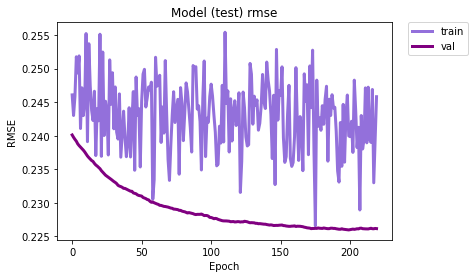

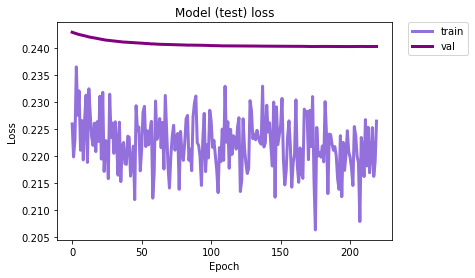

Epoch 1/300
9/9 [==============================] - 1s 110ms/step - loss: 0.2235 - mae: 0.1723 - rmse: 0.2194 - val_loss: 0.1996 - val_mae: 0.1642 - val_rmse: 0.2136
Epoch 2/300
9/9 [==============================] - 1s 96ms/step - loss: 0.2192 - mae: 0.1656 - rmse: 0.2169 - val_loss: 0.1995 - val_mae: 0.1639 - val_rmse: 0.2135
Epoch 3/300
9/9 [==============================] - 1s 70ms/step - loss: 0.2192 - mae: 0.1640 - rmse: 0.2148 - val_loss: 0.1994 - val_mae: 0.1636 - val_rmse: 0.2135
Epoch 4/300
9/9 [==============================] - 1s 87ms/step - loss: 0.2229 - mae: 0.1667 - rmse: 0.2206 - val_loss: 0.1993 - val_mae: 0.1634 - val_rmse: 0.2134
Epoch 5/300
9/9 [==============================] - 1s 97ms/step - loss: 0.2214 - mae: 0.1671 - rmse: 0.2147 - val_loss: 0.1993 - val_mae: 0.1632 - val_rmse: 0.2134
Epoch 6/300
9/9 [==============================] - 1s 95ms/step - loss: 0.2269 - mae: 0.1713 - rmse: 0.2243 - val_loss: 0.1992 - val_mae: 0.1630 - val_rmse: 0.2133
Epoch 7/300
9/9

Epoch 51/300
9/9 [==============================] - 1s 84ms/step - loss: 0.2284 - mae: 0.1658 - rmse: 0.2257 - val_loss: 0.1977 - val_mae: 0.1553 - val_rmse: 0.2127
Epoch 52/300
9/9 [==============================] - 1s 96ms/step - loss: 0.2299 - mae: 0.1685 - rmse: 0.2230 - val_loss: 0.1977 - val_mae: 0.1553 - val_rmse: 0.2127
Epoch 53/300
9/9 [==============================] - 1s 103ms/step - loss: 0.2262 - mae: 0.1622 - rmse: 0.2205 - val_loss: 0.1977 - val_mae: 0.1552 - val_rmse: 0.2127
Epoch 54/300
9/9 [==============================] - 1s 109ms/step - loss: 0.2262 - mae: 0.1651 - rmse: 0.2201 - val_loss: 0.1977 - val_mae: 0.1551 - val_rmse: 0.2127
Epoch 55/300
9/9 [==============================] - 1s 107ms/step - loss: 0.2188 - mae: 0.1609 - rmse: 0.2165 - val_loss: 0.1977 - val_mae: 0.1550 - val_rmse: 0.2127
Epoch 56/300
9/9 [==============================] - 1s 94ms/step - loss: 0.2213 - mae: 0.1615 - rmse: 0.2177 - val_loss: 0.1977 - val_mae: 0.1549 - val_rmse: 0.2127
Epoch 5

9/9 [==============================] - 1s 78ms/step - loss: 0.2199 - mae: 0.1597 - rmse: 0.2128 - val_loss: 0.1976 - val_mae: 0.1525 - val_rmse: 0.2129
Epoch 101/300
9/9 [==============================] - 1s 85ms/step - loss: 0.2232 - mae: 0.1618 - rmse: 0.2197 - val_loss: 0.1976 - val_mae: 0.1525 - val_rmse: 0.2129
Epoch 102/300
9/9 [==============================] - 1s 81ms/step - loss: 0.2259 - mae: 0.1647 - rmse: 0.2229 - val_loss: 0.1976 - val_mae: 0.1525 - val_rmse: 0.2129
Epoch 103/300
9/9 [==============================] - 1s 86ms/step - loss: 0.2187 - mae: 0.1538 - rmse: 0.2138 - val_loss: 0.1976 - val_mae: 0.1524 - val_rmse: 0.2129
Epoch 104/300
9/9 [==============================] - 1s 83ms/step - loss: 0.2281 - mae: 0.1628 - rmse: 0.2248 - val_loss: 0.1976 - val_mae: 0.1524 - val_rmse: 0.2129
Epoch 105/300
9/9 [==============================] - 1s 81ms/step - loss: 0.2212 - mae: 0.1615 - rmse: 0.2164 - val_loss: 0.1976 - val_mae: 0.1524 - val_rmse: 0.2129
Epoch 106/300
9/9 

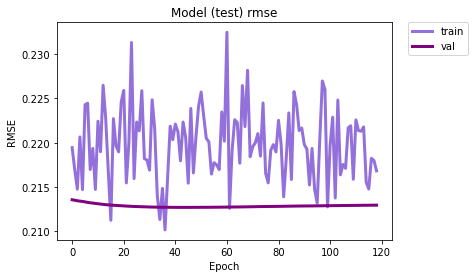

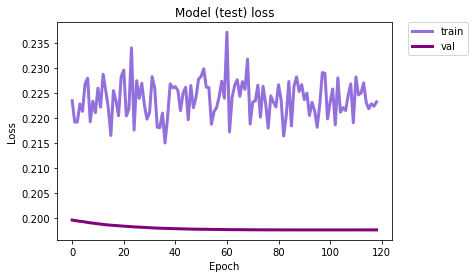

Epoch 1/300
11/11 [==============================] - 1s 89ms/step - loss: 0.2243 - mae: 0.1648 - rmse: 0.2184 - val_loss: 0.2368 - val_mae: 0.1914 - val_rmse: 0.2445
Epoch 2/300
11/11 [==============================] - 1s 82ms/step - loss: 0.2226 - mae: 0.1654 - rmse: 0.2186 - val_loss: 0.2368 - val_mae: 0.1915 - val_rmse: 0.2444
Epoch 3/300
11/11 [==============================] - 1s 84ms/step - loss: 0.2226 - mae: 0.1656 - rmse: 0.2193 - val_loss: 0.2367 - val_mae: 0.1916 - val_rmse: 0.2443
Epoch 4/300
11/11 [==============================] - 1s 85ms/step - loss: 0.2173 - mae: 0.1632 - rmse: 0.2112 - val_loss: 0.2367 - val_mae: 0.1917 - val_rmse: 0.2443
Epoch 5/300
11/11 [==============================] - 1s 101ms/step - loss: 0.2204 - mae: 0.1620 - rmse: 0.2165 - val_loss: 0.2366 - val_mae: 0.1918 - val_rmse: 0.2442
Epoch 6/300
11/11 [==============================] - 1s 102ms/step - loss: 0.2212 - mae: 0.1660 - rmse: 0.2169 - val_loss: 0.2366 - val_mae: 0.1918 - val_rmse: 0.2442
Ep

Epoch 50/300
11/11 [==============================] - 1s 81ms/step - loss: 0.2251 - mae: 0.1682 - rmse: 0.2207 - val_loss: 0.2357 - val_mae: 0.1938 - val_rmse: 0.2431
Epoch 51/300
11/11 [==============================] - 1s 81ms/step - loss: 0.2172 - mae: 0.1636 - rmse: 0.2142 - val_loss: 0.2357 - val_mae: 0.1938 - val_rmse: 0.2431
Epoch 52/300
11/11 [==============================] - 1s 81ms/step - loss: 0.2190 - mae: 0.1674 - rmse: 0.2134 - val_loss: 0.2357 - val_mae: 0.1938 - val_rmse: 0.2431
Epoch 53/300
11/11 [==============================] - 1s 80ms/step - loss: 0.2237 - mae: 0.1674 - rmse: 0.2180 - val_loss: 0.2357 - val_mae: 0.1938 - val_rmse: 0.2431
Epoch 54/300
11/11 [==============================] - 1s 81ms/step - loss: 0.2251 - mae: 0.1696 - rmse: 0.2199 - val_loss: 0.2357 - val_mae: 0.1938 - val_rmse: 0.2431
Epoch 55/300
11/11 [==============================] - 1s 117ms/step - loss: 0.2189 - mae: 0.1639 - rmse: 0.2128 - val_loss: 0.2357 - val_mae: 0.1939 - val_rmse: 0.24

11/11 [==============================] - 1s 65ms/step - loss: 0.2173 - mae: 0.1647 - rmse: 0.2122 - val_loss: 0.2354 - val_mae: 0.1946 - val_rmse: 0.2428
Epoch 100/300
11/11 [==============================] - 1s 57ms/step - loss: 0.2194 - mae: 0.1611 - rmse: 0.2148 - val_loss: 0.2354 - val_mae: 0.1946 - val_rmse: 0.2428
Epoch 101/300
11/11 [==============================] - 1s 70ms/step - loss: 0.2168 - mae: 0.1624 - rmse: 0.2122 - val_loss: 0.2354 - val_mae: 0.1946 - val_rmse: 0.2428
Epoch 102/300
11/11 [==============================] - 1s 75ms/step - loss: 0.2295 - mae: 0.1737 - rmse: 0.2242 - val_loss: 0.2354 - val_mae: 0.1946 - val_rmse: 0.2428
Epoch 103/300
11/11 [==============================] - 1s 77ms/step - loss: 0.2131 - mae: 0.1576 - rmse: 0.2085 - val_loss: 0.2354 - val_mae: 0.1945 - val_rmse: 0.2428
Epoch 104/300
11/11 [==============================] - 1s 75ms/step - loss: 0.2265 - mae: 0.1703 - rmse: 0.2207 - val_loss: 0.2355 - val_mae: 0.1945 - val_rmse: 0.2428
Epoch 

Epoch 148/300
11/11 [==============================] - 1s 85ms/step - loss: 0.2231 - mae: 0.1662 - rmse: 0.2182 - val_loss: 0.2354 - val_mae: 0.1949 - val_rmse: 0.2427
Epoch 149/300
11/11 [==============================] - 1s 93ms/step - loss: 0.2229 - mae: 0.1630 - rmse: 0.2194 - val_loss: 0.2353 - val_mae: 0.1949 - val_rmse: 0.2427
Epoch 150/300
11/11 [==============================] - 1s 81ms/step - loss: 0.2118 - mae: 0.1593 - rmse: 0.2061 - val_loss: 0.2353 - val_mae: 0.1949 - val_rmse: 0.2427
Epoch 151/300
11/11 [==============================] - 1s 87ms/step - loss: 0.2214 - mae: 0.1674 - rmse: 0.2156 - val_loss: 0.2353 - val_mae: 0.1949 - val_rmse: 0.2427
Epoch 152/300
11/11 [==============================] - 1s 86ms/step - loss: 0.2231 - mae: 0.1700 - rmse: 0.2188 - val_loss: 0.2353 - val_mae: 0.1949 - val_rmse: 0.2427
Epoch 153/300
11/11 [==============================] - 1s 81ms/step - loss: 0.2187 - mae: 0.1670 - rmse: 0.2138 - val_loss: 0.2353 - val_mae: 0.1949 - val_rmse:

11/11 [==============================] - 1s 106ms/step - loss: 0.2205 - mae: 0.1648 - rmse: 0.2145 - val_loss: 0.2354 - val_mae: 0.1949 - val_rmse: 0.2427
Epoch 197/300
11/11 [==============================] - 1s 94ms/step - loss: 0.2142 - mae: 0.1580 - rmse: 0.2089 - val_loss: 0.2353 - val_mae: 0.1949 - val_rmse: 0.2427
Epoch 198/300
11/11 [==============================] - 1s 85ms/step - loss: 0.2240 - mae: 0.1660 - rmse: 0.2190 - val_loss: 0.2353 - val_mae: 0.1949 - val_rmse: 0.2427
Epoch 199/300
11/11 [==============================] - 1s 84ms/step - loss: 0.2166 - mae: 0.1603 - rmse: 0.2120 - val_loss: 0.2353 - val_mae: 0.1950 - val_rmse: 0.2427
Epoch 200/300
11/11 [==============================] - 1s 86ms/step - loss: 0.2238 - mae: 0.1656 - rmse: 0.2195 - val_loss: 0.2353 - val_mae: 0.1950 - val_rmse: 0.2427
Epoch 201/300
11/11 [==============================] - 1s 83ms/step - loss: 0.2165 - mae: 0.1628 - rmse: 0.2129 - val_loss: 0.2353 - val_mae: 0.1950 - val_rmse: 0.2427
Epoch

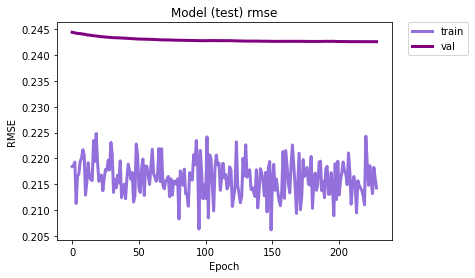

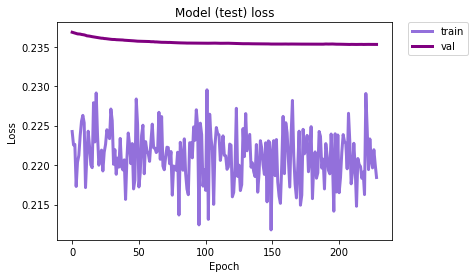

In [16]:
# fitting the model
modelTime = build_model(TIMESTEPS, FEATURES, name = 'test')
modelTime, hist_list, loss_list = compile_and_fit(modelTime, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat -0.70653164
Transformed yhat 6.713098
yhat -0.70866257
Transformed yhat 6.7064962
yhat -0.70924246
Transformed yhat 6.7047
yhat -0.7092186
Transformed yhat 6.704774
yhat -0.70951265
Transformed yhat 6.703863
yhat -0.7096716
Transformed yhat 6.70337
yhat -0.70879126
Transformed yhat 6.706097
yhat -0.70781714
Transformed yhat 6.7091155
yhat -0.707714
Transformed yhat 6.709435
yhat -0.7069596
Transformed yhat 6.7117724
yhat -0.7055534
Transformed yhat 6.716129
yhat -0.70438623
Transformed yhat 6.719744
Real data: [7.4037963  6.43300263 6.42151353 7.5689433  7.93159003 6.72939321
 6.72058255 8.14050838 7.29567189 6.2802258  6.50947915 6.6253217
 6.64509282 6.64509282 7.87449696 5.88638934 5.80392157 5.96928002
 6.97862913 6.17777546 6.17777546 6.47282681 6.17777546 6.17777546]
Forecasting values: [6.7, 6.7, 6.7, 6.7, 6.7, 6.7, 6.7, 6.7, 6.7, 6.7, 6.7, 6.7]


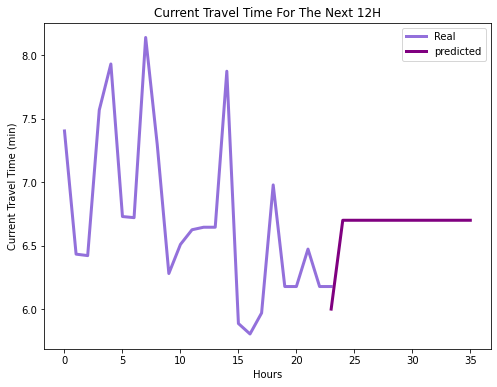

In [17]:
# Recursive Multi-step Forecast
forecasts = forecast(modelTime,normalized_Time, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction(normalized_Time, forecasts, scaler)

In [18]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)

In [19]:
import csv
with open('predictionsTime.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'Cent.0',forecasts[i],hour[i]
        writer.writerow(d)  

# LSTM - Speed

In [20]:
# our supervised problem
x, y = to_supervised(normalized_Speed, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 13s 1s/step - loss: 0.4574 - mae: 0.3920 - rmse: 0.4794 - val_loss: 0.3869 - val_mae: 0.3706 - val_rmse: 0.3869
Epoch 2/300
3/3 [==============================] - 0s 86ms/step - loss: 0.4149 - mae: 0.3519 - rmse: 0.4338 - val_loss: 0.3586 - val_mae: 0.3357 - val_rmse: 0.3586
Epoch 3/300
3/3 [==============================] - 0s 126ms/step - loss: 0.3914 - mae: 0.3268 - rmse: 0.4122 - val_loss: 0.3382 - val_mae: 0.3072 - val_rmse: 0.3382
Epoch 4/300
3/3 [==============================] - 0s 103ms/step - loss: 0.3710 - mae: 0.3078 - rmse: 0.3881 - val_loss: 0.3224 - val_mae: 0.2818 - val_rmse: 0.3224
Epoch 5/300
3/3 [==============================] - 0s 167ms/step - loss: 0.3480 - mae: 0.2858 - rmse: 0.3620 - val_loss: 0.3104 - val_mae: 0.2587 - val_rmse: 0.3104
Epoch 6/300
3/3 [==============================] - 0s 95ms/step - loss: 0.3426 - mae: 0.2775 - rmse: 0.3569 - val_loss: 0.3023 - val_mae: 0.2394 - val_rmse: 0.3023
Epoch 7/300
3/

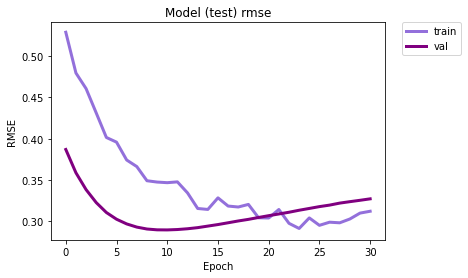

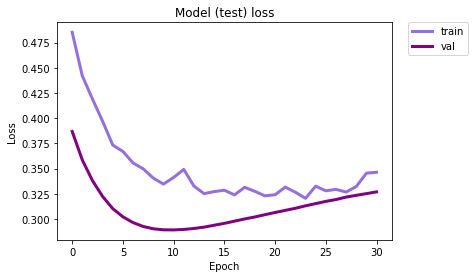

Epoch 1/300
5/5 [==============================] - 1s 181ms/step - loss: 0.3177 - mae: 0.2516 - rmse: 0.2804 - val_loss: 0.3031 - val_mae: 0.2408 - val_rmse: 0.3031
Epoch 2/300
5/5 [==============================] - 1s 141ms/step - loss: 0.3133 - mae: 0.2442 - rmse: 0.2737 - val_loss: 0.3032 - val_mae: 0.2404 - val_rmse: 0.3032
Epoch 3/300
5/5 [==============================] - 1s 160ms/step - loss: 0.3150 - mae: 0.2479 - rmse: 0.2761 - val_loss: 0.3033 - val_mae: 0.2400 - val_rmse: 0.3033
Epoch 4/300
5/5 [==============================] - 0s 101ms/step - loss: 0.3156 - mae: 0.2502 - rmse: 0.2773 - val_loss: 0.3034 - val_mae: 0.2394 - val_rmse: 0.3034
Epoch 5/300
5/5 [==============================] - 0s 105ms/step - loss: 0.3142 - mae: 0.2462 - rmse: 0.2695 - val_loss: 0.3036 - val_mae: 0.2389 - val_rmse: 0.3036
Epoch 6/300
5/5 [==============================] - 1s 164ms/step - loss: 0.3137 - mae: 0.2486 - rmse: 0.2761 - val_loss: 0.3037 - val_mae: 0.2385 - val_rmse: 0.3037
Epoch 7/30

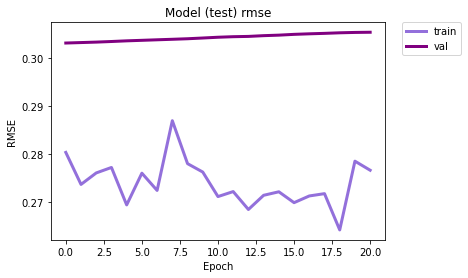

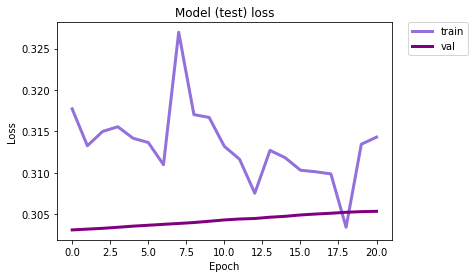

Epoch 1/300
7/7 [==============================] - 1s 114ms/step - loss: 0.3046 - mae: 0.2368 - rmse: 0.3158 - val_loss: 0.3534 - val_mae: 0.3176 - val_rmse: 0.3570
Epoch 2/300
7/7 [==============================] - 0s 74ms/step - loss: 0.3063 - mae: 0.2364 - rmse: 0.3190 - val_loss: 0.3534 - val_mae: 0.3175 - val_rmse: 0.3569
Epoch 3/300
7/7 [==============================] - 1s 126ms/step - loss: 0.3059 - mae: 0.2374 - rmse: 0.3177 - val_loss: 0.3533 - val_mae: 0.3175 - val_rmse: 0.3568
Epoch 4/300
7/7 [==============================] - 1s 111ms/step - loss: 0.3011 - mae: 0.2298 - rmse: 0.3137 - val_loss: 0.3533 - val_mae: 0.3174 - val_rmse: 0.3566
Epoch 5/300
7/7 [==============================] - 1s 103ms/step - loss: 0.3055 - mae: 0.2344 - rmse: 0.3162 - val_loss: 0.3533 - val_mae: 0.3174 - val_rmse: 0.3565
Epoch 6/300
7/7 [==============================] - 1s 96ms/step - loss: 0.3017 - mae: 0.2330 - rmse: 0.3130 - val_loss: 0.3533 - val_mae: 0.3173 - val_rmse: 0.3564
Epoch 7/300


7/7 [==============================] - 1s 95ms/step - loss: 0.3046 - mae: 0.2324 - rmse: 0.3154 - val_loss: 0.3529 - val_mae: 0.3161 - val_rmse: 0.3533
Epoch 51/300
7/7 [==============================] - 1s 85ms/step - loss: 0.2996 - mae: 0.2293 - rmse: 0.3101 - val_loss: 0.3528 - val_mae: 0.3161 - val_rmse: 0.3533
Epoch 52/300
7/7 [==============================] - 1s 78ms/step - loss: 0.3010 - mae: 0.2265 - rmse: 0.3143 - val_loss: 0.3528 - val_mae: 0.3161 - val_rmse: 0.3532
Epoch 53/300
7/7 [==============================] - 1s 85ms/step - loss: 0.3049 - mae: 0.2309 - rmse: 0.3169 - val_loss: 0.3528 - val_mae: 0.3161 - val_rmse: 0.3532
Epoch 54/300
7/7 [==============================] - 1s 102ms/step - loss: 0.3021 - mae: 0.2288 - rmse: 0.3140 - val_loss: 0.3528 - val_mae: 0.3161 - val_rmse: 0.3532
Epoch 55/300
7/7 [==============================] - 1s 81ms/step - loss: 0.3014 - mae: 0.2303 - rmse: 0.3141 - val_loss: 0.3528 - val_mae: 0.3161 - val_rmse: 0.3531
Epoch 56/300
7/7 [====

7/7 [==============================] - 1s 144ms/step - loss: 0.3007 - mae: 0.2266 - rmse: 0.3118 - val_loss: 0.3527 - val_mae: 0.3155 - val_rmse: 0.3515
Epoch 100/300
7/7 [==============================] - 1s 133ms/step - loss: 0.3006 - mae: 0.2274 - rmse: 0.3137 - val_loss: 0.3527 - val_mae: 0.3155 - val_rmse: 0.3515
Epoch 101/300
7/7 [==============================] - 1s 104ms/step - loss: 0.2996 - mae: 0.2309 - rmse: 0.3134 - val_loss: 0.3527 - val_mae: 0.3154 - val_rmse: 0.3515
Epoch 102/300
7/7 [==============================] - 1s 169ms/step - loss: 0.2929 - mae: 0.2227 - rmse: 0.3045 - val_loss: 0.3527 - val_mae: 0.3154 - val_rmse: 0.3514
Epoch 103/300
7/7 [==============================] - 1s 104ms/step - loss: 0.2997 - mae: 0.2268 - rmse: 0.3124 - val_loss: 0.3527 - val_mae: 0.3154 - val_rmse: 0.3514
Epoch 104/300
7/7 [==============================] - 0s 70ms/step - loss: 0.3020 - mae: 0.2317 - rmse: 0.3140 - val_loss: 0.3527 - val_mae: 0.3154 - val_rmse: 0.3514
Epoch 105/300

7/7 [==============================] - 1s 84ms/step - loss: 0.3021 - mae: 0.2286 - rmse: 0.3145 - val_loss: 0.3526 - val_mae: 0.3152 - val_rmse: 0.3506
Epoch 149/300
7/7 [==============================] - 1s 94ms/step - loss: 0.3037 - mae: 0.2306 - rmse: 0.3178 - val_loss: 0.3526 - val_mae: 0.3152 - val_rmse: 0.3506
Epoch 150/300
7/7 [==============================] - 1s 145ms/step - loss: 0.3029 - mae: 0.2314 - rmse: 0.3148 - val_loss: 0.3526 - val_mae: 0.3152 - val_rmse: 0.3506
Epoch 151/300
7/7 [==============================] - 1s 107ms/step - loss: 0.3021 - mae: 0.2303 - rmse: 0.3151 - val_loss: 0.3526 - val_mae: 0.3152 - val_rmse: 0.3506
Epoch 152/300
7/7 [==============================] - 1s 94ms/step - loss: 0.3001 - mae: 0.2273 - rmse: 0.3121 - val_loss: 0.3526 - val_mae: 0.3152 - val_rmse: 0.3506
Epoch 153/300
7/7 [==============================] - 0s 56ms/step - loss: 0.3034 - mae: 0.2299 - rmse: 0.3157 - val_loss: 0.3526 - val_mae: 0.3152 - val_rmse: 0.3505
Epoch 154/300
7/

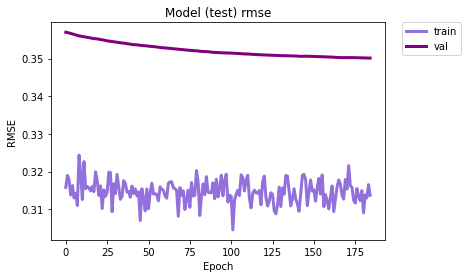

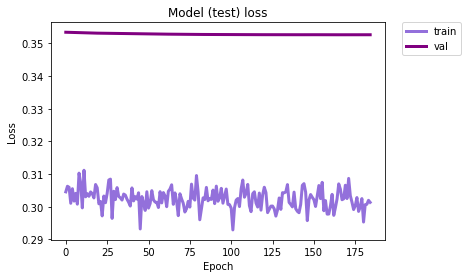

Epoch 1/300
9/9 [==============================] - 1s 84ms/step - loss: 0.3070 - mae: 0.2432 - rmse: 0.3080 - val_loss: 0.3075 - val_mae: 0.2585 - val_rmse: 0.3301
Epoch 2/300
9/9 [==============================] - 1s 105ms/step - loss: 0.3020 - mae: 0.2376 - rmse: 0.3013 - val_loss: 0.3074 - val_mae: 0.2582 - val_rmse: 0.3300
Epoch 3/300
9/9 [==============================] - 1s 78ms/step - loss: 0.3069 - mae: 0.2416 - rmse: 0.3074 - val_loss: 0.3073 - val_mae: 0.2580 - val_rmse: 0.3299
Epoch 4/300
9/9 [==============================] - 1s 100ms/step - loss: 0.3091 - mae: 0.2415 - rmse: 0.3084 - val_loss: 0.3072 - val_mae: 0.2577 - val_rmse: 0.3298
Epoch 5/300
9/9 [==============================] - 1s 99ms/step - loss: 0.3101 - mae: 0.2437 - rmse: 0.3131 - val_loss: 0.3071 - val_mae: 0.2575 - val_rmse: 0.3297
Epoch 6/300
9/9 [==============================] - 1s 97ms/step - loss: 0.3067 - mae: 0.2421 - rmse: 0.3061 - val_loss: 0.3069 - val_mae: 0.2572 - val_rmse: 0.3296
Epoch 7/300
9/

Epoch 51/300
9/9 [==============================] - 1s 65ms/step - loss: 0.3087 - mae: 0.2397 - rmse: 0.3065 - val_loss: 0.3037 - val_mae: 0.2539 - val_rmse: 0.3272
Epoch 52/300
9/9 [==============================] - 1s 65ms/step - loss: 0.3093 - mae: 0.2417 - rmse: 0.3080 - val_loss: 0.3036 - val_mae: 0.2539 - val_rmse: 0.3272
Epoch 53/300
9/9 [==============================] - 1s 66ms/step - loss: 0.3067 - mae: 0.2386 - rmse: 0.3062 - val_loss: 0.3036 - val_mae: 0.2539 - val_rmse: 0.3271
Epoch 54/300
9/9 [==============================] - 1s 63ms/step - loss: 0.3078 - mae: 0.2406 - rmse: 0.3058 - val_loss: 0.3036 - val_mae: 0.2539 - val_rmse: 0.3271
Epoch 55/300
9/9 [==============================] - 1s 65ms/step - loss: 0.3036 - mae: 0.2379 - rmse: 0.3053 - val_loss: 0.3035 - val_mae: 0.2539 - val_rmse: 0.3271
Epoch 56/300
9/9 [==============================] - 1s 61ms/step - loss: 0.3041 - mae: 0.2366 - rmse: 0.3025 - val_loss: 0.3035 - val_mae: 0.2539 - val_rmse: 0.3271
Epoch 57/3

9/9 [==============================] - 1s 75ms/step - loss: 0.3061 - mae: 0.2364 - rmse: 0.3037 - val_loss: 0.3024 - val_mae: 0.2538 - val_rmse: 0.3264
Epoch 101/300
9/9 [==============================] - 1s 64ms/step - loss: 0.3050 - mae: 0.2390 - rmse: 0.3013 - val_loss: 0.3024 - val_mae: 0.2538 - val_rmse: 0.3264
Epoch 102/300
9/9 [==============================] - 1s 62ms/step - loss: 0.3043 - mae: 0.2335 - rmse: 0.2999 - val_loss: 0.3024 - val_mae: 0.2538 - val_rmse: 0.3264
Epoch 103/300
9/9 [==============================] - 1s 79ms/step - loss: 0.3069 - mae: 0.2358 - rmse: 0.3042 - val_loss: 0.3024 - val_mae: 0.2538 - val_rmse: 0.3264
Epoch 104/300
9/9 [==============================] - 1s 73ms/step - loss: 0.3028 - mae: 0.2358 - rmse: 0.3010 - val_loss: 0.3024 - val_mae: 0.2538 - val_rmse: 0.3264
Epoch 105/300
9/9 [==============================] - 1s 87ms/step - loss: 0.3027 - mae: 0.2334 - rmse: 0.2990 - val_loss: 0.3024 - val_mae: 0.2538 - val_rmse: 0.3264
Epoch 106/300
9/9 

9/9 [==============================] - 1s 66ms/step - loss: 0.3054 - mae: 0.2358 - rmse: 0.3033 - val_loss: 0.3020 - val_mae: 0.2538 - val_rmse: 0.3263
Epoch 150/300
9/9 [==============================] - 0s 55ms/step - loss: 0.3070 - mae: 0.2411 - rmse: 0.3041 - val_loss: 0.3020 - val_mae: 0.2538 - val_rmse: 0.3263
Epoch 151/300
9/9 [==============================] - 1s 58ms/step - loss: 0.3053 - mae: 0.2363 - rmse: 0.2998 - val_loss: 0.3020 - val_mae: 0.2538 - val_rmse: 0.3263
Epoch 152/300
9/9 [==============================] - 1s 62ms/step - loss: 0.3013 - mae: 0.2338 - rmse: 0.2987 - val_loss: 0.3020 - val_mae: 0.2538 - val_rmse: 0.3263
Epoch 153/300
9/9 [==============================] - 1s 62ms/step - loss: 0.3015 - mae: 0.2343 - rmse: 0.2975 - val_loss: 0.3020 - val_mae: 0.2538 - val_rmse: 0.3263
Epoch 154/300
9/9 [==============================] - 1s 62ms/step - loss: 0.3016 - mae: 0.2327 - rmse: 0.2967 - val_loss: 0.3020 - val_mae: 0.2538 - val_rmse: 0.3263
Epoch 155/300
9/9 

9/9 [==============================] - 1s 79ms/step - loss: 0.3072 - mae: 0.2359 - rmse: 0.3040 - val_loss: 0.3019 - val_mae: 0.2539 - val_rmse: 0.3263
Epoch 199/300
9/9 [==============================] - 1s 65ms/step - loss: 0.3036 - mae: 0.2336 - rmse: 0.2989 - val_loss: 0.3019 - val_mae: 0.2539 - val_rmse: 0.3263
Epoch 200/300
9/9 [==============================] - 1s 63ms/step - loss: 0.3056 - mae: 0.2359 - rmse: 0.3021 - val_loss: 0.3019 - val_mae: 0.2539 - val_rmse: 0.3263
Epoch 201/300
9/9 [==============================] - 1s 71ms/step - loss: 0.3054 - mae: 0.2362 - rmse: 0.3004 - val_loss: 0.3019 - val_mae: 0.2539 - val_rmse: 0.3263
Epoch 202/300
9/9 [==============================] - 1s 77ms/step - loss: 0.3089 - mae: 0.2383 - rmse: 0.3043 - val_loss: 0.3019 - val_mae: 0.2539 - val_rmse: 0.3263
Epoch 203/300
9/9 [==============================] - 1s 63ms/step - loss: 0.2992 - mae: 0.2304 - rmse: 0.2957 - val_loss: 0.3019 - val_mae: 0.2539 - val_rmse: 0.3263
Epoch 204/300
9/9 

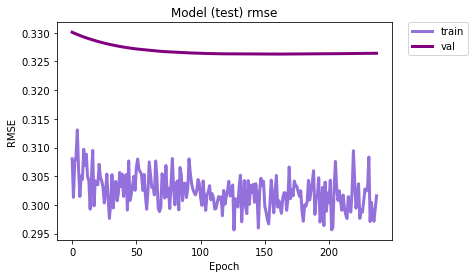

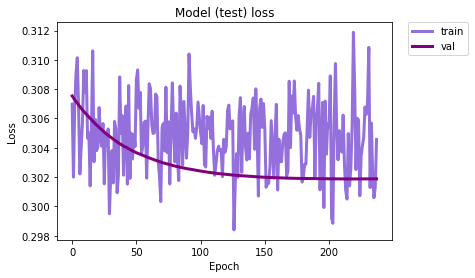

Epoch 1/300
11/11 [==============================] - 1s 88ms/step - loss: 0.3039 - mae: 0.2367 - rmse: 0.2969 - val_loss: 0.3330 - val_mae: 0.2738 - val_rmse: 0.3417
Epoch 2/300
11/11 [==============================] - 1s 86ms/step - loss: 0.3093 - mae: 0.2414 - rmse: 0.3025 - val_loss: 0.3330 - val_mae: 0.2738 - val_rmse: 0.3417
Epoch 3/300
11/11 [==============================] - 1s 82ms/step - loss: 0.3033 - mae: 0.2365 - rmse: 0.2962 - val_loss: 0.3330 - val_mae: 0.2738 - val_rmse: 0.3417
Epoch 4/300
11/11 [==============================] - 1s 89ms/step - loss: 0.3100 - mae: 0.2409 - rmse: 0.3025 - val_loss: 0.3330 - val_mae: 0.2738 - val_rmse: 0.3416
Epoch 5/300
11/11 [==============================] - 1s 83ms/step - loss: 0.3080 - mae: 0.2389 - rmse: 0.3012 - val_loss: 0.3330 - val_mae: 0.2739 - val_rmse: 0.3416
Epoch 6/300
11/11 [==============================] - 1s 92ms/step - loss: 0.3079 - mae: 0.2400 - rmse: 0.3010 - val_loss: 0.3330 - val_mae: 0.2739 - val_rmse: 0.3416
Epoc

11/11 [==============================] - 1s 86ms/step - loss: 0.3047 - mae: 0.2370 - rmse: 0.2986 - val_loss: 0.3327 - val_mae: 0.2756 - val_rmse: 0.3411
Epoch 51/300
11/11 [==============================] - 1s 82ms/step - loss: 0.3005 - mae: 0.2350 - rmse: 0.2934 - val_loss: 0.3327 - val_mae: 0.2756 - val_rmse: 0.3411
Epoch 52/300
11/11 [==============================] - 1s 82ms/step - loss: 0.3033 - mae: 0.2369 - rmse: 0.2958 - val_loss: 0.3327 - val_mae: 0.2756 - val_rmse: 0.3411
Epoch 53/300
11/11 [==============================] - 1s 110ms/step - loss: 0.3071 - mae: 0.2413 - rmse: 0.2993 - val_loss: 0.3327 - val_mae: 0.2757 - val_rmse: 0.3411
Epoch 54/300
11/11 [==============================] - 1s 115ms/step - loss: 0.3058 - mae: 0.2389 - rmse: 0.2991 - val_loss: 0.3327 - val_mae: 0.2757 - val_rmse: 0.3411
Epoch 55/300
11/11 [==============================] - 1s 133ms/step - loss: 0.3057 - mae: 0.2383 - rmse: 0.2986 - val_loss: 0.3327 - val_mae: 0.2758 - val_rmse: 0.3411
Epoch 56

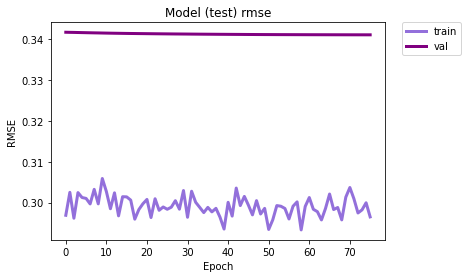

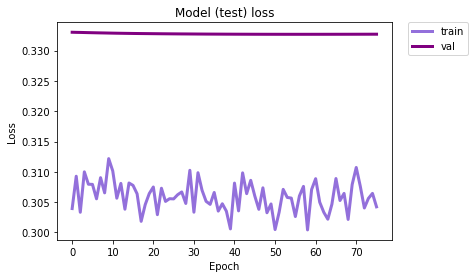

In [21]:
# fitting the model
modelSpeed = build_model(TIMESTEPS, FEATURES, name = 'test')
modelSpeed , hist_list, loss_list = compile_and_fit(modelSpeed, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat 0.39618912
Transformed yhat 10.12937
yhat 0.39676708
Transformed yhat 10.131161
yhat 0.39545444
Transformed yhat 10.127094
yhat 0.3932904
Transformed yhat 10.12039
yhat 0.39117217
Transformed yhat 10.113827
yhat 0.38900867
Transformed yhat 10.107125
yhat 0.3865558
Transformed yhat 10.099525
yhat 0.38428658
Transformed yhat 10.092496
yhat 0.38264447
Transformed yhat 10.087409
yhat 0.38092813
Transformed yhat 10.082091
yhat 0.37907645
Transformed yhat 10.076354
yhat 0.3775582
Transformed yhat 10.0716505
Real data: [ 8.8627451  10.46153846 10.58823529  8.75        8.35294118  9.88235294
  9.90384615  8.03921569  9.23529412 10.82692308 10.39215686 10.28846154
 10.         10.          8.53846154 11.88235294 12.         11.69230769
  9.64705882 11.         11.         10.50980392 11.         11.        ]
Forecasting values: [10.1, 10.1, 10.1, 10.1, 10.1, 10.1, 10.1, 10.1, 10.1, 10.1, 10.1, 10.1]


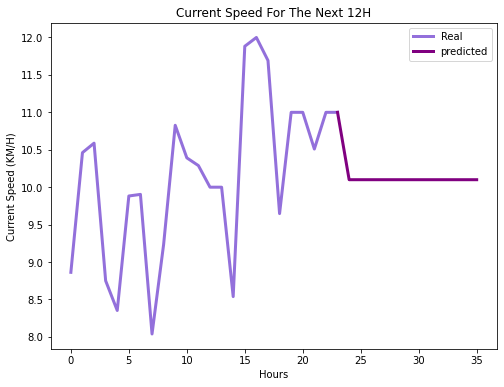

In [22]:
# Recursive Multi-step Forecast
forecastSpeed = forecast(modelSpeed,normalized_Speed, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction_Speed(normalized_Speed, forecastSpeed, scaler)

In [23]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)

In [24]:
import csv

with open('predictionsSpeed.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'Cent.0',forecastSpeed[i],hour[i]
        writer.writerow(d)